## Import and globals

In [2]:
from IO import read_kitty, write_one_kitty
import yaml
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torchinfo import summary as info_summary
from itertools import chain, repeat, product, islice
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score

%matplotlib inline
config = yaml.safe_load(open('./net_config.yaml'))
print(*config.items(), sep='\n')

('generator', {'lr': 0.001})
('discriminator', {'lr': 0.001})
('data_loader', {'train': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'valid': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'test': ['30', '34', '35', '36', '76']})
('run', {'device': 1, 'cuda': True, 'seed': 42})
('train', {'disc_loops': 3, 'batch_size': 1, 'max_epoch': 5, 'log_name': 'id_test', 'checkpoint': False})
('eval', {'save': 2})


## Build dataloader

In [3]:
def describe_data():
    points, labels = read_kitty(config['data_loader']['train'], max_len=1)
    sample = next(iter(points['11'].values()))
    print('Point cloud shape:', sample.shape)
    print(*sample[:5],sep='\n')
    sample = next(iter(labels['11'].values()))
    print('\nLabel shape:', sample.shape)
    print(*sample[:5],sep='\n')
describe_data()

Point cloud shape: (115881, 4)
[-197.84776     26.662176     3.9865794   13.       ]
[-197.78802     25.835665     2.8061757    6.       ]
[-197.77983     25.658987     1.0338181   10.       ]
[-197.77368     26.125235     2.2110257    9.       ]
[-197.7581      26.23899      3.3880968   13.       ]

Label shape: (115881, 2)
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


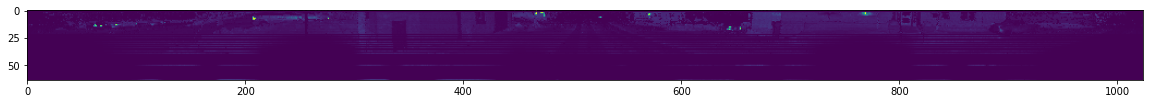

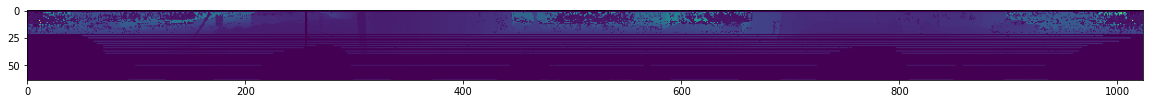

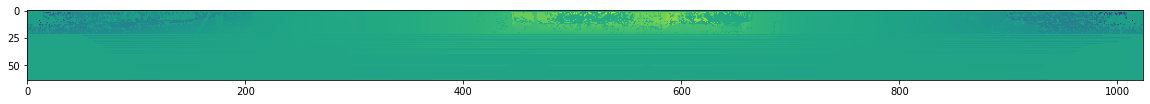

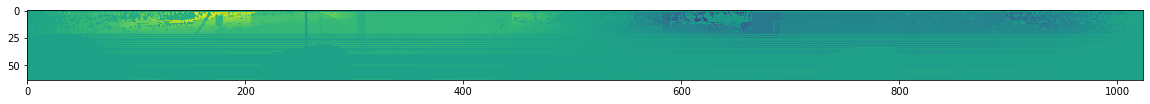

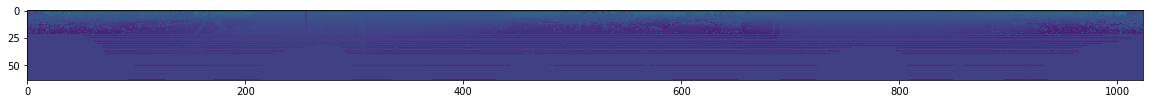

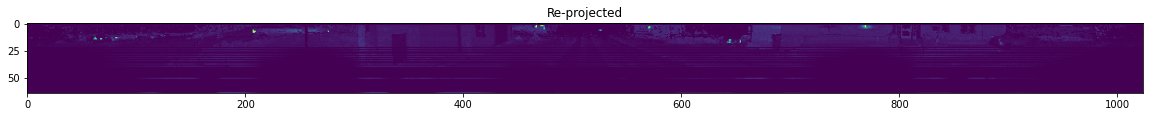

In [4]:
def project(points, vertical_fov:tuple=(3.0,-25.0), out_shape:tuple=(64,1024)):
    # unpack params to short names
    P = points.copy()
    fov_up, fov_down = vertical_fov
    height, width = out_shape
    x, y, z = P[:,0], P[:,1], P[:,2]

    # Compute spherical coordinates
    r = LA.norm(P[:,:3], 2, axis=1)
    yaw = -np.arctan2(y, x)
    pitch = np.arcsin(z / r)
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad

    # get projections in image coords
    clamp = lambda x,m: np.maximum(0, np.minimum(np.round(x),m)).astype(np.int32)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in the set [0.0, 1.0]
    proj_x *= width  # in [0.0, W]
    proj_x = clamp(proj_x, width-1) # in [0,W-1]
    
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in the set [0.0, 1.0]
    proj_y *= height  # in [0.0, H]
    proj_y = clamp(proj_y, height-1)  # in [0,H-1]

    # order in decreasing depth
    rev_indices = np.arange(r.shape[0])
    indices = np.argsort(r)[::-1]
    P, proj_y, proj_x = P[indices], proj_y[indices], proj_x[indices]
    r, rev_indices = r[indices], rev_indices[indices]
    
    # build projected image data
    proj = np.full((height, width, 6), -1, dtype=np.float32)
    proj[proj_y, proj_x, 0] = P[:,3]
    proj[proj_y, proj_x, 1] = r
    proj[proj_y, proj_x, 2:5] = P[:,0:3]
    proj[proj_y, proj_x, 5] = rev_indices
    
    return proj


def unproject(projection, vertical_fov:tuple=(3.0,-25.0), return_mask=False):
    "convert 2d image to 3d point cloud. [height, width, channels] -> [index, channels]"
    
    fov_up, fov_down = vertical_fov
    height, width, channels = projection.shape
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad
    
    # compute point cloud
    p = -np.ones((height*width, 4), dtype=np.float32) # init as -1 to remove dead pixels later
    for y,x in product(range(height), range(width)):
        #compute target index
        index = y*width+x # or x*height+y
        
        # Get spherical coordinates
        intensity, r = projection[y, x, :2]
        if r == -1: continue # if magic number -1 then there's no data
        x /= width # normalize
        yaw = 2.0 * np.pi * (-x) 
        y /= height # normalize
        pitch = fov*(1.0-y) - abs(fov_down) - np.pi/2
        
        # Compute cartesian coordinates
        x = np.cos(yaw) * np.sin(pitch) * r
        y = np.sin(yaw) * np.sin(pitch) * r
        z = np.cos(pitch) * r
        
        # Add data to array
        p[index, 0] = x
        p[index, 1] = y
        p[index, 2] = z
        p[index, 3] = intensity
        
    mask = p[:,3]!=-1
    p = p[mask] # remove points with no data
    
    if return_mask:
        return p, mask
    return p
 

# print sample images to validate
points, labels = read_kitty(config['data_loader']['train'], max_len=1)
sample = next(iter(points['18'].values()))
projected = project(sample)

for i in range(0,5):
    plt.figure(figsize=(20, 6));
    plt.imshow(projected[:,:,i]);

# sanity check. intensity sum should be the same before and after
assert unproject(projected)[:,3].sum() == projected[:,:,0].sum() + sum(projected[:,:,0].flat==-1)
# sanity check. unprojected points can't be further away than max radius
assert max(projected[:,:,1].flat) > max([max(abs(unproject(projected)[:,i])) for i in range(3)])

plt.figure(figsize=(20, 6));
plt.title('Re-projected')
plt.imshow((project(unproject(projected)))[:,:,0]);

In [23]:
outlier_labels = [110] # 110 = falling snow
seq_lenths = 10

# declare iterators to flatten nested dicts (sorry about the itertool mess)
flat_values = lambda points: chain(*chain((*p.values(),) for p in points.values()))
flat_keys = lambda points: chain(*chain((*zip( repeat(k, len(p.keys())), p.keys() ),) for k,p in points.items()))

# train loader
points, labels = read_kitty(config['data_loader']['train'], max_len=seq_lenths)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,:-4].transpose(2, 0, 1) for p in flat_values(points)] 
train_loader = torch.utils.data.DataLoader(
    [*zip(snowy,clean)], #[*zip(snowy,clean)],
    shuffle=True, 
    batch_size=config['train']['batch_size'])
x,y = next(iter(train_loader))
print(x.shape, y.shape)

# test loader
points, labels = read_kitty(config['data_loader']['test'], max_len=seq_lenths*3)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,[0,1,5]].transpose(2, 0, 1) for p in flat_values(points)] # keep last channel (rev indices)
rev_indices = [data[-1,:,:].astype(np.int32) for data in snowy] # extract reverse indices
snowy = [s[:-1,:,:] for s in snowy] # drop them
label = [lab[i].transpose(2, 0, 1) for lab,i in zip(flat_values(labels),rev_indices)]
keys = [*flat_keys(labels)]
test_loader = torch.utils.data.DataLoader(
    [*zip(snowy, clean, label, keys)], #[*zip(snowy, clean, label, keys)],
    shuffle=False,
    batch_size=config['train']['batch_size'])
x,y,l,k = next(iter(test_loader))
print(x.shape, y.shape, l.shape, k)

torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024])
torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) [('30',), ('041570',)]


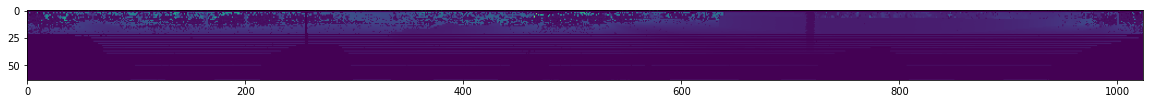

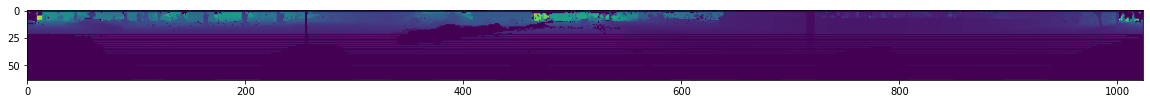

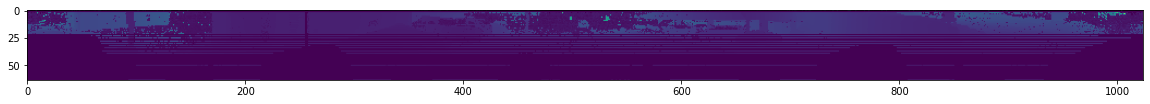

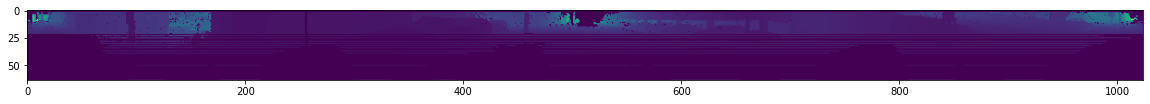

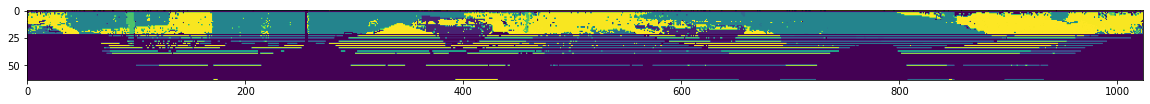

In [6]:
def display_loader(loader, plot_dim:int=1):
    x,y,*rest = next(iter(loader))
    plt.figure(figsize=(20, 6))
    plt.imshow(x[0,plot_dim,:,:]);
    plt.figure(figsize=(20, 6))
    plt.imshow(y[0,plot_dim,:,:]);
    if rest:
        l, k = rest
        plt.figure(figsize=(20, 6))
        plt.imshow(l[0,0,:,:]);
        
display_loader(train_loader)
display_loader(test_loader)

## Build net

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# Reference
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>
    

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids) # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net
    
############## Blocks ##############
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters, bias=True):
        super(ResContextBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        self.activ = nn.LeakyReLU()
        
        layers  = [nn.Conv2d(in_filters, out_filters, 1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(in_filters, out_filters, 5, padding=2, bias=bias)]
        layers += relu_and_norm()
        layers += [nn.Conv2d(out_filters, out_filters, 3, dilation=3, padding=3, bias=bias)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)
        resA = self.block(x)
        out = self.activ(shortcut + resA)
        return out
    
    
class DownBlock(nn.Module):
    def __init__(self, in_filters, out_filters, stride:int=2, drop_out:float=0.0, bias=True):
        super(DownBlock, self).__init__()
        self.stride = stride > 1
        self.drop_out = drop_out
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        self.activ = nn.LeakyReLU()

        layers  = [nn.Conv2d(in_filters, out_filters, 1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)

        layers  = [nn.Conv2d(in_filters, out_filters, 3, padding=1, bias=bias)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=2, padding=2, bias=bias)]
        layers += relu_and_norm()
        self.path2 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 2, dilation=2, padding=1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.path3 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(3*out_filters, out_filters, 1, bias=bias)]
        self.path4 = nn.Sequential(*layers)

        self.dropout = nn.Dropout2d(p=drop_out)
        if self.stride:
            #self.pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            layers  = [nn.PixelUnshuffle(stride)]
            layers += [nn.Conv2d(stride*stride*out_filters, out_filters, 1, bias=bias)]
            layers += [nn.LeakyReLU()]
            self.pool = nn.Sequential(*layers)
            
    def forward(self, x):
        shortcut = self.skip_path(x)

        resA1 = self.path1(x)
        resA2 = self.path2(resA1)
        resA3 = self.path3(resA2)

        concat = torch.cat((resA1, resA2, resA3),dim=1)
        resA = self.path4(concat)
        resA += shortcut
        resA = self.activ(resA)

        resB = self.dropout(resA) if self.drop_out else resA

        if self.stride:
            resB = self.pool(resB)
            return resB, resA
        return resB
    
            
class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(UpBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.PixelShuffle(2)]
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        #layers += [nn.Conv2d(in_filters>>2, out_filters, 1, padding=0)]
        self.up_path = nn.Sequential(*layers)

        layers  = [nn.Dropout2d(p=drop_out)] if drop_out else []
        layers += [nn.Conv2d(in_filters//4 + 2*out_filters, out_filters, 1, padding=0)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=1, padding=1)]
        layers += [nn.LeakyReLU()]
        self.path2 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1)]
        layers += relu_and_norm()
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        self.path4 = nn.Sequential(*layers)

    def forward(self, x, skip):
        upA = self.up_path(x) 
        upB = torch.cat((upA,skip),dim=1)
    
        upE1 = self.path1(upB)
        upE2 = self.path2(upE1)

        concat = torch.cat((upE1, upE2),dim=1)
        upE = self.path4(concat)
        return upE
    
############## encode ##############
class Encoder(nn.Module):
    def __init__(self, ratio:float=.5):
        super(Encoder, self).__init__()
        assert 0.0 <= ratio and ratio <= 1.0, 'ratio must be between 0 and 1'
        self.ratio = ratio
        in_chnl = 2
        
        layer_list = [
            'cntx-32', 'cntx-32', 'marker', # Pre process
            'down-64', 'down-128', 'down-256', 'marker', # Encode
            'res-256', # Process features
        ]
        markers = [i for i,x in enumerate(layer_list) if x=='marker'] # Extract markers
        markers = [x-i for i,x in enumerate(markers)]
        layer_list = [l for l in layer_list if l != 'marker']
        
        name2block = {
            'cntx':lambda i,o: ResContextBlock(i, o),
            'down':lambda i,o: DownBlock(i, o, stride=2, drop_out=False),
            'res': lambda i,o: DownBlock(i, o, stride=1, drop_out=False),
        }
        
        layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        m = markers
        self.pre  = nn.Sequential(*layers[   0:m[0]])
        self.down =                layers[m[0]:m[1]]
        self.post = nn.Sequential(*layers[m[1]:])
        
        self.dummy = nn.Sequential(*layers) # so pytorch can see the layers
        
    def forward(self, x):
        pre  = self.pre(x)
        skips = [pre]
        down = pre
        for d in self.down:
            down, skip = d(down)
            skips += [skip]
        post = self.post(down)
        skips = [*reversed(skips)] # decoders want reverse order

        # split output into 2 domains
        l = post.shape[1]
        domain1 = int(l*self.ratio)
        domain1, domain2 = torch.split(post, [domain1, l-domain1], dim=1)
        return domain1, domain2, skips
    
############## decode ##############
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        in_chnl = 256
        
        layer_list = [
            'up-128', 'up-64', 'up-32', 'marker', # Decode
            'cntx-32', 'c-1', # Post process
        ]
        markers = [i for i,x in enumerate(layer_list) if x=='marker'] # Extract markers
        markers = [x-i for i,x in enumerate(markers)]
        layer_list = [l for l in layer_list if l != 'marker']
        
        name2block = {
            'up': lambda i,o: UpBlock(i, o, drop_out=False),
            'cntx':lambda i,o: ResContextBlock(i, o),
            'c'  :lambda i,o: nn.Conv2d(i, o, 1),
        }
        
        layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        m = markers
        self.up   =                layers[   0:m[0]]
        self.post = nn.Sequential(*layers[m[0]:])
        
        self.dummy = nn.Sequential(*layers) # so pytorch can see the layers
        
    def forward(self, x, skips):
        up  = x
        for u,s in zip(self.up, skips):
            up = u(up,s)
        post = self.post(up)
        return post
        
############## Disc ##############
class Discriminator(nn.Module):
    def __init__(self, channels:int=256):
        super(Discriminator, self).__init__()
        layers  = [ResContextBlock(channels ,channels, bias=False)]
        layers += [nn.Conv2d(channels, 1, (4,64), padding=0, bias=False)]
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
        
############## ToDomain ##############
class ToDomain(nn.Module):
    def __init__(self, channels:int=2):
        super(ToDomain, self).__init__()
        self.encoder  = Encoder()
        self.disc     = Discriminator()
        
    def forward(self, x):
        domain1, domain2, skips = self.encoder(x)
        disc1  = torch.cat((domain1, torch.zeros_like(domain2)), dim=1)
        disc2  = torch.cat((torch.zeros_like(domain1), domain2), dim=1)
        disc1  = self.disc(disc1)
        disc2  = self.disc(disc2)
        return domain1, domain2, skips, disc1, disc2
    
############## FromDomain ##############   
class FromDomain(nn.Module):
    def __init__(self, channels:int=2):
        super(FromDomain, self).__init__()
        self.mask     = Decoder()
        self.residual = Decoder()
        
    def forward(self, x, d1, d2, skips):
        enc = torch.cat((d1, d2), dim=1)
        m = self.mask(enc, skips)
        m = torch.sigmoid(m)
        #m = torch.ones_like(m) ## mask override!
        m = m * x.ge(0) # leverage that -1 input -> no change
        res = self.residual(enc, skips)
        return x+res*m, m
    
############## Combined ##############   
class Combined(nn.Module):
    def __init__(self, channels:int=2):
        super(Combined, self).__init__()
        self.td = ToDomain()
        self.fd = FromDomain(channels=channels)
        
    def forward(self, x):
        dom1, dom2, skips, disc1, disc2 = self.td(x)
        out = self.fd(x, dom1, dom2, skips)
        return out, disc1, disc2


def summarise():
    #print('ToDomain\n')
    #print(summary(ToDomain().to(0), (2, 64, 1024)))
    #print(info_summary(ToDomain().to(0), input_size=(1, 2, 64, 1024)))

    print('\nCombined:')
    #summary(Discriminator().cuda(), (5, 64, 1024))
    print(info_summary(Combined().to(1), 
                       input_size=(1, 2, 64, 1024),
                       device=1,
                       verbose=0,
                       depth=5))
summarise()


Combined:
Layer (type:depth-idx)                                  Output Shape              Param #
Combined                                                --                        --
├─ToDomain: 1-1                                         [1, 128, 8, 128]          --
│    └─Encoder: 2-1                                     [1, 128, 8, 128]          --
│    │    └─Sequential: 3-1                             [1, 32, 64, 1024]         --
│    │    │    └─ResContextBlock: 4-1                   [1, 32, 64, 1024]         --
│    │    │    │    └─Sequential: 5-1                   [1, 32, 64, 1024]         96
│    │    │    │    └─Sequential: 5-2                   [1, 32, 64, 1024]         10,944
│    │    │    │    └─LeakyReLU: 5-3                    [1, 32, 64, 1024]         --
│    │    │    └─ResContextBlock: 4-2                   [1, 32, 64, 1024]         --
│    │    │    │    └─Sequential: 5-4                   [1, 32, 64, 1024]         1,056
│    │    │    │    └─Sequential: 5-5     

## Train net

In [28]:
import torch.optim as optim
import torchvision.transforms as transforms
import itertools
import os
import cv2

# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


class ToNumpy(object):
    def __call__(self, data):
        return data.cpu().detach().numpy().transpose(0, 2, 3, 1)


def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

                
def train(train_loader, encoder, disc, decoder, optimizer, optimizerD, l_cycle, l_disc, l_recon, l_l1, epoch, writer, config):
    encoder.train()
    decoder.train()
        
    for i, (dataA, dataB) in enumerate(train_loader):
        ## Train Discriminator
        # Note: discriminate domain1! not domain2 (encoder learns domain2)
        if config['run']['cuda']:
            dataA = dataA.to(config['run']['device'])
            dataB = dataB.to(config['run']['device'])
            
        set_requires_grad([encoder], False)
        set_requires_grad([disc], True)
        optimizerD.zero_grad()
        
        # Forward
        domain1A, domain2A, skipsA = encoder(dataA)
        domain1B, domain2B, skipsB = encoder(dataB)
        disc_1A = disc(domain1A)
        disc_1B = disc(domain1B)

        # loss
        loss_disc  = l_disc(disc_1A, torch.ones_like(disc_1A)) 
        loss_disc += l_disc(disc_1B, torch.zeros_like(disc_1B))
        
        loss_disc.backward()
        nn.utils.clip_grad_norm_(disc.parameters(), 5)
        optimizerD.step()
            
        ## Train Encoder
        for dA, dB in islice(train_loader, config['train']['disc_loops']):
            if config['run']['cuda']:
                dA = dA.to(config['run']['device'])
                dB = dB.to(config['run']['device'])
            
            set_requires_grad([encoder], True)
            set_requires_grad([disc], False)
            optimizer.zero_grad()
            
            # Forward 
            domain1A, domain2A, skipsA = encoder(dA)
            domain1B, domain2B, skipsB = encoder(dB)
            disc_1A = disc(domain1A)
            disc_1B = disc(domain1B)
            disc_2A = disc(domain2A)
            disc_2B = disc(domain2B)
            
            # Loss
            ones = torch.ones_like(disc_1A)
            zeros = torch.zeros_like(disc_1A)
            
            loss_inter  = l_disc(disc_1A, ones) + l_disc(disc_1A, zeros)
            loss_inter += l_disc(disc_1B, ones) + l_disc(disc_1B, zeros)
            loss_inter += torch.log(torch.tensor(2**-4)) # adjust min to 0
            loss_disc   = l_disc(disc_2A, torch.ones_like(disc_2A)) 
            loss_disc  += l_disc(disc_2B, torch.zeros_like(disc_2B))
            loss = 4*loss_disc + loss_inter
            
            loss.backward()
            nn.utils.clip_grad_norm_(encoder.parameters(), 5)
            optimizer.step()
            
        ## Train encoder/decoder
        set_requires_grad([encoder], True)
        set_requires_grad([disc], False)
        set_requires_grad([decoder], True)
        optimizer.zero_grad()
        
        # Forward pass
        domain1A, domain2A, skipsA = encoder(dataA)
        domain1B, domain2B, skipsB = encoder(dataB)
        reA, _  = decoder(dataA, domain1A, domain2A, skipsA)
        reB, _  = decoder(dataB, domain1B, domain2B, skipsB)
        A2B, mA = decoder(dataA, domain1A, domain2A, skipsA)
        B2A, mB = decoder(dataB, domain1B, domain2B, skipsB)
        
        # Loss
        loss_recon = l_recon(dataA, reA) + l_recon(dataB, reB)
        loss_l1    = l_l1(A2B, dataB) + l_l1(B2A, dataA) # only for labeled data, replace this
        loss       = 0*loss_recon + loss_l1 ##!!
        
        loss.backward()
        nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        
        ## Log train info
        toNumpy = lambda x: x.cpu().detach().numpy()
        dataB, A2B = toNumpy(dataB), toNumpy(A2B)
        span = 255 # manually set! dataA.max() sort of works if unkown
        # mean of funcion f applied to each channel for each image in batch
        apply = lambda f: np.mean([f(d, r, data_range=span) for da,ra in zip(dataB, A2B) for d,r in zip(da,ra)])
        metrics = {
            'Loss_inter': loss_inter.item(),
            'Loss_disc':loss_disc.item(),
            'Loss_recon':loss_recon,
            'Loss_l1':loss_l1.item(),
            'psnr_A': apply(psnr),
            #'ssim_A': apply(ssim),
        }
        iteration = len(train_loader)*(epoch-1)+i
        for k,v in metrics.items():
            writer.add_scalars(k, {config['train']['log_name']:v}, iteration)
        
        # Display train info
        print(f'\r[Epoch: {epoch:4d}][{1+i:4d}]',
              *[f'{k}: {v:.4f},' for k,v in metrics.items()],
              end=' '*10)

        # Create checkpoint
        if config['train']['checkpoint']:
            if i % config['train']['checkpoint'] == 0:
                if not os.path.isdir('E:/cyclegan/checkpoints'):
                    os.mkdir('E:/cyclegan/checkpoints')

                torch.save({
                    'generator': generator.state_dict(),
                    'optimizer': optimizerG.state_dict(),
                    'start_epoch': epoch,
                }, './runs/model_{}_{}.pth'.format(epoch, i))


def evaluation(test_loader, encoder, disc, decoder, config):
    encoder.eval()
    decoder.eval()

    transform_inv = transforms.Compose([UnNormalize(mean=(0.0, 0.0), std=(1.0, 1.0)), ToNumpy()])
    toNumpy = lambda x: x.cpu().detach().numpy()
    accuracy = lambda x,y: (np.round(x)==y).mean()
    tot_metrics = {}
        
    saved = 0
    with torch.no_grad():
        for i, (dataA, dataB, labels, keys) in enumerate(test_loader):
            
            if config['run']['cuda']:
                dataA = dataA.to(config['run']['device'])
                dataB = dataB.to(config['run']['device'])

            domain1A, domain2A, skipsA = encoder(dataA)
            domain1B, domain2B, skipsB = encoder(dataB)
            d = [torch.sigmoid(torch.mean(disc(x))).item() for x in [domain1A, domain2A, domain1B, domain2B]]
            A2B, mA = decoder(dataA, domain1A, domain2B, skipsA)
            
            # Display eval info
            toNumpy = lambda x: x.cpu().detach().numpy()
            np_dB, np_gB = toNumpy(dataB), toNumpy(A2B)
            span = 255 # manually set! data.max() sort of works if unkown
            # mean of funcion f applied to each channel for each image in batch
            apply = lambda f: np.mean([f(d, r, data_range=span) for da,ra in zip(np_dB, np_gB) for d,r in zip(da,ra)])
            metrics = { 
                'x_mean': A2B.mean(),
                'y_mean': dataB.mean(),
                'psnr_A': apply(psnr),
                'ssim_A': apply(ssim),
                'dA1':d[0],
                'dA2':d[1],
                'dB1':d[2],
                'dB2':d[3],
            }
            tot_metrics = {k:tot_metrics.get(k,0) + v for k,v in metrics.items()}
            print(f'\r[Eval Iter: {1+i:4d}]',
                  *[f'{k}: {v/(1+i):.4f},' for k,v in tot_metrics.items()],
                  end=' '*10)
            
            # Log eval info
            data = {'input':dataA, 
                    'out':A2B,
                    'mask':mA}
            data = {k:transform_inv(v) for k,v in data.items()}

            if saved < config['eval']['save']:
                if not os.path.isdir('results'):
                    os.mkdir('results')
                
                max_saves = config['eval']['save'] - saved
                batch_size = dataA.shape[0]
                for j in range(0, min(batch_size, max_saves)):
                    number = batch_size * i + j
                    saved += 1
                    for k,image in data.items():
                        name = f'{k}_{number:0>4d}'
                        (*folder_id,), (*file_name,) = keys
                        save_data('./results', name, image[j], labels[j], (folder_id[j],file_name[j]) )
                        
    
def save_data(folder, name, projection, labels=None, keys:tuple=None):
    "Saves a 2d and an unprojected 3d image"
    
    def normalize(img):
        i = img.copy()
        power = 1/4 # prevents extremes from using the full pallete
        i[i<0] = -np.power(-i[i<0],power)
        i[i>0] =  np.power( i[i>0],power)
        i -= i.min()
        return i / i.max()
    
    # make 2d image  
    x = projection
    img = np.concatenate([normalize(x[:,:,i]) for i in range(x.shape[2])], axis=0)
    
    if not os.path.isdir('./results/2d'):
        os.mkdir('./results/2d')
    plt.imsave(folder+'/2d/'+name+'.png', img)
    
    if keys: # make 3d image
        folder_id, file_name = keys
        folder = folder+'/'+'_'.join(name.split('_')[:1])
        points, mask = unproject(projection, return_mask=True)
        frame = {file_name:points}
        
        label = labels
        if label != None:
            # Flatten labels the same way unprojection is done
            channel, height, width = labels.shape
            label = -np.ones((height*width, channel), dtype=np.int16)
            l = labels.detach().cpu().numpy()
            for y,x in product(range(height), range(width)):
                index = y*width+x
                label[index] = l[:,y,x]
            label = {file_name:label[mask]}
        write_one_kitty(folder, frame, labels=label)
        

def main():
    checkpoint = None
    do_train = True
    config = yaml.safe_load(open('./net_config.yaml'))
    
    torch.manual_seed(config['run']['seed'])
    torch.cuda.manual_seed(config['run']['seed'])
    np.random.seed(config['run']['seed'])
    
    encoder = Encoder()
    disc    = Discriminator(channels=128)
    decoder = FromDomain()

    if config['run']['cuda']:
        encoder = encoder.to(config['run']['device'])
        decoder = decoder.to(config['run']['device'])

    optimizer = optim.Adam(
        itertools.chain(encoder.parameters(), decoder.parameters()), 
        lr=config['generator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)
    
    optimizerD = optim.Adam(
        itertools.chain(disc.parameters()), 
        lr=config['discriminator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)

    if checkpoint:
        path = 'E:/cyclegan/checkpoints/model_{}_{}.pth'.format(285, 200)

        checkpoint = torch.load(path)
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])
        optimizer.load_state_dict(checkpoint['optimizer'])

        start_epoch = 285
    else:
        for net in [encoder, disc, decoder]:
            init_net(net, init_type='kaiming', init_gain=0.02, gpu_ids=[config['run']['device']])
        start_epoch = 1

    if do_train:
        l_cycle = nn.MSELoss()
        l_disc  = nn.BCEWithLogitsLoss()
        l_l1    = nn.L1Loss()
        l_recon = nn.L1Loss()
        writer = SummaryWriter('results/'+'logs')
        
        for epoch in range(start_epoch, config['train']['max_epoch']+1):
            train(train_loader, encoder, disc, decoder, optimizer, optimizerD, l_cycle, l_disc, l_recon, l_l1, epoch, writer, config)
            print()            
        writer.close()
        
    evaluation(test_loader, encoder, disc, decoder, config)
    print()

main()

[Epoch:    1][ 130] Loss_inter: 0.1777, Loss_disc: 0.0016, Loss_recon: 1.2917, Loss_l1: 8.0523, psnr_A: 25.3580,             
[Epoch:    2][ 130] Loss_inter: 0.2743, Loss_disc: 0.0008, Loss_recon: 0.9858, Loss_l1: 2.8546, psnr_A: 31.0553,          
[Epoch:    3][ 130] Loss_inter: 0.0243, Loss_disc: 0.0002, Loss_recon: 1.0093, Loss_l1: 2.8284, psnr_A: 32.0916,          
[Epoch:    4][ 130] Loss_inter: 0.2404, Loss_disc: 0.0001, Loss_recon: 1.4711, Loss_l1: 3.2589, psnr_A: 31.6612,          
[Epoch:    5][ 130] Loss_inter: 0.0175, Loss_disc: 0.0001, Loss_recon: 1.8640, Loss_l1: 5.6334, psnr_A: 28.4707,          
[Epoch:    6][ 130] Loss_inter: 0.0202, Loss_disc: 0.0007, Loss_recon: 1.6625, Loss_l1: 5.6771, psnr_A: 28.1003,          
[Epoch:    7][ 130] Loss_inter: 0.2293, Loss_disc: 0.0020, Loss_recon: 1.1077, Loss_l1: 2.8422, psnr_A: 31.1213,          
[Epoch:    8][ 130] Loss_inter: 0.0274, Loss_disc: 0.0001, Loss_recon: 0.9809, Loss_l1: 2.6473, psnr_A: 32.6115,          
[Epoch:    9]

In [8]:
[Epoch:    5][  65] Loss_inter: 0.9274, Loss_disc: 3.8330, Loss_recon: 0.0000, Loss_l1: 4.1588, psnr_A: 28.4317,          
[Eval Iter:   23] x_mean: 4.8972, y_mean: 6.5542, psnr_A: 30.0636, ssim_A: 0.9174, dA1: 0.9214, dA2: 0.9955, dB1: 0.8541, dB2: 0.0009,   

[Epoch:    5][ 130] Loss_inter: 0.2265, Loss_disc: 0.0000, Loss_recon: 2.3033, Loss_l1: 5.3979, psnr_A: 28.3860,          
[Eval Iter:   45] x_mean: 5.0912, y_mean: 6.5671, psnr_A: 30.6147, ssim_A: 0.9289, dA1: 0.4521, dA2: 0.0000, dB1: 0.3924, dB2: 0.0000,                 

SyntaxError: invalid syntax (2088951427.py, line 1)

In [29]:
!zip -r ./results/results.zip ./results/input ./results/out ./results/2d > /dev/null

In [ ]:
!tensorboard --logdir="results/logs" --port=6060

## TODO

- pass identity test
- pass random data test
- try nudged adam
- reverse projection | rangeNet https://github.com/PRBonn/rangenet_lib | https://www.ipb.uni-bonn.de/wp-content/papercite-data/pdf/milioto2019iros.pdf
section III- D
- improve net | ref https://github.com/Halmstad-University/TITAN-NET


- do semantic segementation with only one generator
- do generation with one GAN

### Notes
- intersection: decoder fools disc, disc does disc stuff
- domain: decoder matches disc, disc does disc stuff
- 1 disc vs 2: 1 has 2 constraints. 2 has variable input length
- try one. exclude disc gradient from decoder training and train disc adversly only!
- use one train step per input-output path


- Make nice figure
- Remove points (and replace)
- Figure out how this is unsupervised